Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Taylon xxxxx (RA: 0000000)
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)

# Lista 01

## Tarefa

Trabalhar com a base de dados U.S. Airline Traffic Data, a qual contém informações referentes ao tráfego aéreo mensal norte-americano no período de 2003 a 2023, disponibilizadas pelo U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics. Em particular, vamos explorar a série temporal do número total de vôos (domésticos e internacionais).

Explorar um modelo linear para a previsão considerando que o horizonte de predição é L = 1 (passos à frente da série temporal).

## Dataset

* [Lista01\air traffic.csv](https://www.kaggle.com/datasets/yyxian/u-s-airline-traffic-data/data)

* This dataset provides U.S. monthly airline traffic from 2003 to 2023, including number of passengers, number of flights, revenue passenger-miles (RPM), available seat-miles (ASM) and load factor.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
from itertools import chain
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
df = pd.read_csv("air traffic.csv")

In [8]:
df.describe()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
count,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000
mean,2012.879518,6.445783,5.520971e+07,7.392209e+06,6.260192e+07,706750.710843,64736.172691,771486.883534,4.957803e+07,1.918103e+07,6.875906e+07,6.131822e+07,2.413903e+07,8.545724e+07,79.938394,77.304940,79.286305
std,6.002817,3.442803,1.044055e+07,2.020273e+06,1.229211e+07,107054.971522,12129.622461,115686.728629,1.035558e+07,5.711621e+06,1.548875e+07,8.996673e+06,5.650437e+06,1.382385e+07,8.860562,10.907145,8.895700
min,2003.000000,1.000000,2.877290e+06,1.366090e+05,3.013899e+06,217262.000000,4996.000000,222280.000000,2.551127e+06,3.567620e+05,2.907889e+06,1.948908e+07,1.541419e+06,2.103050e+07,13.090000,23.150000,13.830000
25%,2008.000000,3.000000,5.098217e+07,6.395022e+06,5.766458e+07,662000.000000,61615.000000,727898.000000,4.458029e+07,1.660284e+07,6.182568e+07,5.655552e+07,2.173119e+07,7.919780e+07,77.720000,76.430000,76.940000
50%,2013.000000,6.000000,5.620010e+07,7.419187e+06,6.389913e+07,709933.000000,66557.000000,779011.000000,4.985794e+07,1.968901e+07,6.900519e+07,6.088909e+07,2.464572e+07,8.505191e+07,82.120000,79.910000,81.580000
75%,2018.000000,9.000000,6.089213e+07,8.567847e+06,6.944743e+07,781804.000000,71924.000000,848650.000000,5.568257e+07,2.266760e+07,7.803987e+07,6.626877e+07,2.770535e+07,9.255187e+07,85.240000,82.930000,84.070000
max,2023.000000,12.000000,7.537816e+07,1.243262e+07,8.781077e+07,890938.000000,82681.000000,964102.000000,7.226790e+07,3.137600e+07,1.036439e+08,8.199740e+07,3.532619e+07,1.173122e+08,89.960000,89.440000,89.140000


In [20]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
#df['Year'] + (df['Month']-1) / 12
df['Days_in_month'] = df['Date'].dt.days_in_month


[a] Exiba o gráfico da série temporal completa. Numa inspeção visual simples, é possível reconhecer ao menos três faixas distintas de comportamento aproximadamente “regular” na série: 
    
* (i) Jan/2003 a Ago/2008; 
* (ii) Set/2008 a Dez/2019; 
* (iiI) Jan/2020 a Set/2023.

Discuta possíveis razões históricas/econômicas para as
transições de comportamento.

In [26]:
df['Date'][3]

Timestamp('2003-04-01 00:00:00')

In [28]:
pd.to_datetime('2003-04-01')

Timestamp('2003-04-01 00:00:00')

In [31]:
def can_iterate(a):
    if isinstance(a, str):
        return False
    try:
        iter(a)
        return True
    except TypeError:
        return False

def to_datetime(a):
    if can_iterate(a):
        for i,ai in enumerate(a):
            a[i] = to_datetime(ai)
    else:
        return to_datetime(a)

date_regions = [
    ('2003-01-01', '2008-08-01'),
    ('2008-09-01', '2019-12-01'),
    ('2020-01-01', '2023-09-01')
]

to_datetime(date_regions)

RecursionError: maximum recursion depth exceeded

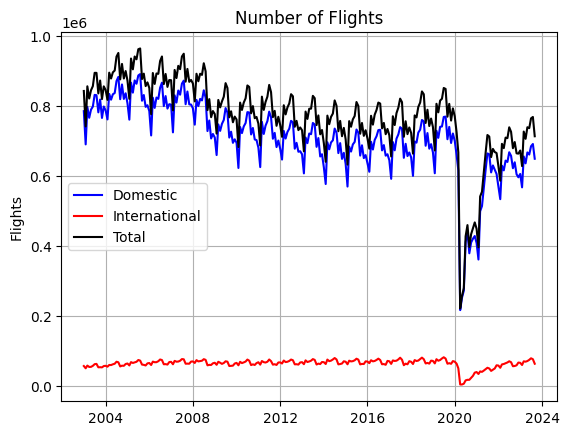

In [24]:
plt.plot(df['Date'], df['Dom_Flt'],
         color='blue', linestyle='-', marker='',
         label='Domestic')
plt.plot(df['Date'], df['Int_Flt'],
         color='red', linestyle='-', marker='',
         label='International')
plt.plot(df['Date'], df['Flt'],
         color='black', linestyle='-', marker='',
         label='Total')

date_regions = [
    ('2003-01-01', '2008-08-01'),
    ('2008-09-01', '2019-12-01'),
    ('2020-01-01', '2023-09-01')
]

plt.axvspan(, 2008 + 7/12, color='green', alpha=0.3)
# plt.axvspan(2008 + 7/12, color='yellow', alpha=0.3)

plt.ylabel('Flights')
plt.title('Number of Flights')
plt.legend()
plt.grid(True)
plt.show()